<a href="https://colab.research.google.com/github/vence-andersen/M5-Forecasting-Accuracy/blob/main/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Removables**

In [1]:
# from google.colab import files
# files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c m5-forecasting-accuracy

sell_prices.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sales_train_evaluation.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sales_train_validation.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
calendar.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip sales_train_evaluation.csv.zip
!unzip sales_train_validation.csv.zip
!unzip sample_submission.csv.zip
!unzip sell_prices.csv.zip

Archive:  sales_train_evaluation.csv.zip
replace sales_train_evaluation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  sales_train_validation.csv.zip
replace sales_train_validation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  sell_prices.csv.zip
replace sell_prices.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! pip install downcast
! pip install catboost

# **Importing modules required**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
from lightgbm import LGBMRegressor, Dataset
from sklearn.metrics import mean_squared_error as mse
from downcast import reduce
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_pickle('/content/drive/MyDrive/new.pkl')
data.head(2)

,id,item_id,dept_id,cat_id,store_id,state_id,day,demand,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,lag_30,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70,rolling_median_5,rolling_median_7,rolling_median_28,rolling_median_56
30490000,14370,1437,3,1,0,0,1001,2,11339,7,10,2013,-1,-1,-1,-1,0,0,0,8.257812,1.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
30490001,14380,1438,3,1,0,0,1001,0,11339,7,10,2013,-1,-1,-1,-1,0,0,0,3.970703,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.drop(['rolling_median_5','rolling_median_7','rolling_median_28','rolling_median_56'],axis=1, inplace=True)

# **Train, Test, Cross Validation for the model**

In [ ]:
X_test

,id,item_id,dept_id,cat_id,store_id,state_id,day,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_28,lag_30,lag_35,lag_42,lag_49,lag_56,lag_63,lag_70
59181090,14370,1437,3,1,0,0,1942,11617,3,5,2016,-1,-1,-1,-1,0,0,0,8.382812,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0
59181091,14380,1438,3,1,0,0,1942,11617,3,5,2016,-1,-1,-1,-1,0,0,0,3.970703,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
59181092,14390,1439,3,1,0,0,1942,11617,3,5,2016,-1,-1,-1,-1,0,0,0,2.970703,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
59181093,14400,1440,3,1,0,0,1942,11617,3,5,2016,-1,-1,-1,-1,0,0,0,4.640625,0.0,7.0,4.0,2.0,1.0,0.0,4.0,3.0
59181094,14410,1441,3,1,0,0,1942,11617,3,5,2016,-1,-1,-1,-1,0,0,0,2.880859,1.0,2.0,0.0,2.0,0.0,1.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60034805,14329,1432,2,0,9,2,1969,11621,2,6,2016,16,3,2,0,0,0,0,2.980469,1.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0
60034806,14339,1433,2,0,9,2,1969,11621,2,6,2016,16,3,2,0,0,0,0,2.480469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
60034807,14349,1434,2,0,9,2,1969,11621,2,6,2016,16,3,2,0,0,0,0,3.980469,2.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0
60034808,14359,1435,2,0,9,2,1969,11621,2,6,2016,16,3,2,0,0,0,0,1.280273,0.0,1.0,1.0,1.0,0.0,3.0,1.0,2.0


In [ ]:
# Now we are splitting our data into, Train, Test, Cross Validate.
# Being a time series model, we are splitting the data based on time.

# Records till day 1914 will be used for training the model.
X_train = data[data['day']<1914]

# Records between days 1914 and 1941 will be used for Validation
X_val = data[(data['day']>=1914) & (data['day']<=1941)]

# Records after day 1942 will used for final test
X_test = data[(data['day']>=1942)]

y_train = X_train['demand']
y_val = X_val['demand']

# We are drpping the features which are not required.
X_train.drop(['demand'],axis = 1,inplace = True)
X_val.drop(['demand'],axis = 1,inplace = True)
X_test.drop(['demand'],axis = 1,inplace = True)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape)

(27837370, 27) (27837370,)
(853720, 27) (853720,)
(853720, 27)


# **LightGBM**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

# We are randomly creating values to chose the best model out of it.
for i in range(15):
    lr = np.round(np.random.rand()/10,3)
    num_leaves = np.random.randint(30,150)
    min_data_in_leaf = np.random.randint(50,150)

    lgb = LGBMRegressor( learning_rate=lr ,
                            num_leaves=num_leaves ,
                            min_data_in_leaf=min_data_in_leaf)

    lgb.fit(X_train, y_train)

    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = lgb.predict(X_val)

    # Now that it has predicted the values for X_val, we are calculating it's rmse
    rmse = mse(y_val,y_pred)
    
    print(f"For learning rate {lr}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {rmse} ")
    print('*'*80)

For learning rate 0.002, num_leaves 88 and min_data_in_leaf 101 the RMSE is 10.832683887724896 
********************************************************************************
For learning rate 0.098, num_leaves 75 and min_data_in_leaf 137 the RMSE is 4.968174905835645 
********************************************************************************
For learning rate 0.002, num_leaves 141 and min_data_in_leaf 112 the RMSE is 10.79968686064402 
********************************************************************************
For learning rate 0.046, num_leaves 48 and min_data_in_leaf 59 the RMSE is 5.087707910063227 
********************************************************************************
For learning rate 0.003, num_leaves 127 and min_data_in_leaf 121 the RMSE is 9.869213241625621 
********************************************************************************
For learning rate 0.048, num_leaves 83 and min_data_in_leaf 60 the RMSE is 5.048882772795383 
************************

In [ ]:
# After running several combinations, we found these parameter values to give best result

learning_rate = 0.074
num_leaves = 135
min_data_in_leaf = 85

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

lgb = LGBMRegressor( learning_rate=learning_rate ,
                           num_leaves=num_leaves ,
                           min_data_in_leaf=min_data_in_leaf)

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)

# Now that it has predicted the values for X_val, we are calculating it's rmse
rmse = mse(y_val,y_pred)
print(f"For learning rate {learning_rate}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {rmse} ")

For learning rate 0.074, num_leaves 135 and min_data_in_leaf 85 the RMSE is 4.950359727619904 


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = lgb.predict(X_val)
pred_test_array  = lgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.799588,0.645370,0.641794,0.448406,1.064329,0.843335,0.852100,0.645981,1.169686,0.797205,1.376487,1.241466,1.313712,1.106001,0.409688,1.263560,0.647822,0.775764,0.977554,0.968038,1.000216,0.772389,0.834312,0.861474,1.271876,0.882477,1.437780,0.864342
1,HOBBIES_1_002_CA_1_validation,0.479410,0.309233,0.286147,0.467108,0.312115,0.466354,0.411817,0.341612,0.188894,0.190332,0.455880,0.289769,0.404054,0.388092,0.332718,0.187964,0.189278,0.357802,0.277328,0.389065,0.369874,0.281671,0.185981,0.308553,0.276324,0.335107,0.351893,0.317738
2,HOBBIES_1_003_CA_1_validation,0.385282,0.370340,0.247326,0.229080,0.477530,0.861790,0.553976,0.266724,0.470021,0.227718,0.339799,0.403145,0.926628,0.481725,0.279453,0.378297,0.337651,0.607883,0.649974,1.191439,1.090290,0.466353,0.763585,0.545274,0.585207,0.740711,0.593700,0.886735
3,HOBBIES_1_004_CA_1_validation,2.104940,0.924101,0.655443,1.374880,1.348142,1.694091,3.249665,1.513807,0.962241,0.789539,1.530276,1.638773,2.046877,2.932853,2.041138,1.220400,1.275514,0.941228,1.591666,1.749986,3.092693,1.991466,1.166458,1.428839,1.072431,1.645722,2.932608,2.664173
4,HOBBIES_1_005_CA_1_validation,1.102642,0.905447,1.092956,1.153426,1.376168,1.235788,1.393084,1.042960,1.242448,0.827937,1.155087,0.841499,0.964488,1.148300,1.142616,0.895113,1.118775,0.753149,1.172041,0.962394,1.347521,0.969909,0.806979,0.826401,1.096487,1.358503,1.227127,1.899966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.424802,0.364086,0.265664,0.607138,0.708331,0.595606,0.644126,0.371990,0.548850,0.293324,0.818991,0.860918,0.485506,0.734509,0.586671,0.568860,0.487472,0.581000,0.882994,0.499202,1.071348,0.421663,1.012529,0.569860,0.486409,0.765294,0.494413,0.825367
60976,FOODS_3_824_WI_3_evaluation,0.524135,0.422416,0.404122,0.529297,0.398298,0.583771,0.414125,0.411346,0.490179,0.379149,0.782174,0.400031,0.692022,0.491843,0.537621,0.468741,0.395849,0.630370,0.292981,0.526711,0.479228,0.467580,0.485285,0.426313,0.567511,0.290997,0.662989,0.327479
60977,FOODS_3_825_WI_3_evaluation,1.207754,0.516295,0.713288,0.386425,0.777298,0.956284,0.621568,1.189630,0.350201,0.811301,0.511487,0.671554,0.834038,0.812919,1.150259,0.828587,1.222356,1.020999,0.707706,0.939133,0.797814,1.204301,0.716252,1.515883,0.420809,0.627383,0.664861,0.927193
60978,FOODS_3_826_WI_3_evaluation,0.900915,1.621368,0.842450,1.235490,1.166573,0.977472,1.590655,1.188748,1.051457,1.124529,1.313323,1.272789,1.388324,1.519350,1.497345,1.132482,1.044251,1.225493,1.286686,1.081658,1.271115,1.361364,1.793947,1.387193,1.485323,1.028043,1.098043,1.116738


In [ ]:
sub.to_csv("lgb_sub_Final.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f lgb_sub_Final.csv -m "Test"

100% 32.7M/32.7M [00:01<00:00, 19.9MB/s]
Successfully submitted to M5 Forecasting - Accuracy

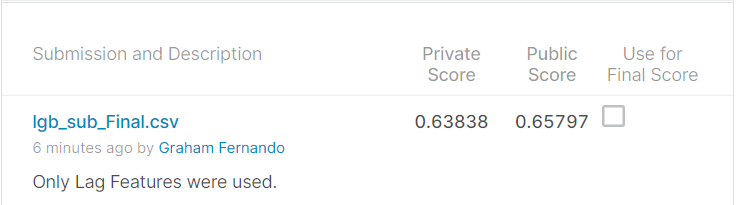

# **CATBOOST**

In [ ]:
# We are training our model with multiple parameter values to get the best parameter to be used for the model.

# We are randomly creating values to chose the best model out of it.
for i in range(8):
    lr = np.round(np.random.rand()/10,3)
    num_leaves = np.random.randint(30,150)
    min_data_in_leaf = np.random.randint(50,150)

    cbr = CatBoostRegressor(learning_rate=lr ,
                        # num_leaves=num_leaves ,
                        min_data_in_leaf=min_data_in_leaf,
                        logging_level="Silent", iterations=130)

    cbr.fit(X_train, y_train)

    # After training the model, we are trying to predict the model on X_val to check it's accuracy
    y_pred = cbr.predict(X_val)

    # Now that it has predicted the values for X_val, we are calculating it's rmse
    rmse = mse(y_val,y_pred)
    
    print(f"For learning rate {lr}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {rmse} ")
    print('*'*80)

For learning rate 0.019, num_leaves 100 and min_data_in_leaf 102 the RMSE is 5.419876429147273 
********************************************************************************
For learning rate 0.008, num_leaves 122 and min_data_in_leaf 81 the RMSE is 6.850490625428555 
********************************************************************************
For learning rate 0.001, num_leaves 69 and min_data_in_leaf 83 the RMSE is 11.78894793346842 
********************************************************************************
For learning rate 0.049, num_leaves 148 and min_data_in_leaf 140 the RMSE is 5.097142515545817 
********************************************************************************
For learning rate 0.076, num_leaves 51 and min_data_in_leaf 74 the RMSE is 5.053819531311917 
********************************************************************************
For learning rate 0.083, num_leaves 72 and min_data_in_leaf 132 the RMSE is 5.05435332052517 
**************************

In [ ]:
# After running several combinations, we found these parameter values to give best result

learning_rate = 0.076
min_data_in_leaf = 74

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

cbr = CatBoostRegressor(learning_rate=learning_rate, min_data_in_leaf = min_data_in_leaf, iterations=100, logging_level="Silent")

cbr.fit(X_train, y_train)
y_pred = cbr.predict(X_val)

# Now that it has predicted the values for X_val, we are calculating it's rmse
rmse = mse(y_val,y_pred)
print(f"For learning rate {learning_rate}, num_leaves {num_leaves} and min_data_in_leaf {min_data_in_leaf} the RMSE is {rmse} ")

For learning rate 0.076, num_leaves 77 and min_data_in_leaf 74 the RMSE is 5.0757273973153305 


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = cbr.predict(X_val)
pred_test_array  = cbr.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.759291,0.675727,0.622414,0.417870,0.874934,0.759985,0.893501,0.672850,1.283154,0.806120,1.286596,1.038762,1.158641,1.014613,0.448364,1.220198,0.637966,0.773619,0.864877,1.030581,0.924418,0.768182,0.826945,0.779513,1.161436,0.900227,1.170368,0.900737
1,HOBBIES_1_002_CA_1_validation,0.474225,0.343653,0.317252,0.433971,0.306976,0.422524,0.403703,0.379159,0.260630,0.249689,0.410760,0.313532,0.404293,0.355077,0.341201,0.249689,0.251307,0.356313,0.295288,0.378430,0.377331,0.316578,0.239241,0.345277,0.314031,0.365643,0.357849,0.331448
2,HOBBIES_1_003_CA_1_validation,0.383375,0.388243,0.278414,0.252014,0.399051,0.899087,0.540365,0.321687,0.498540,0.262462,0.364987,0.379654,1.004840,0.444534,0.301072,0.382555,0.370116,0.586191,0.688742,1.219863,0.893798,0.462463,0.672517,0.503797,0.556581,0.685776,0.550524,0.751260
3,HOBBIES_1_004_CA_1_validation,2.019737,1.097675,0.630498,1.382622,1.263499,1.737507,3.068237,1.318417,1.092962,0.772047,1.451939,1.444433,1.880252,2.984367,1.931839,1.072875,1.274722,0.942771,1.424384,1.642020,2.876963,1.856963,1.271084,1.264248,1.137928,1.431611,2.719613,2.624107
4,HOBBIES_1_005_CA_1_validation,0.982999,0.897309,1.175194,1.069939,1.187452,1.120617,1.409780,0.900511,1.318492,0.908506,1.166500,0.747734,0.842147,1.084173,1.091981,0.812233,1.067622,0.763412,1.024155,0.820688,1.217417,0.903749,0.760385,0.807709,0.981992,1.224430,1.109122,1.698049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.417199,0.333757,0.257576,0.573204,0.669065,0.521685,0.591577,0.373260,0.509443,0.270324,0.790922,0.768215,0.413354,0.632738,0.585116,0.508697,0.445915,0.564686,0.801735,0.465584,1.075794,0.379978,0.977135,0.524553,0.508310,0.699555,0.457451,0.797685
60976,FOODS_3_824_WI_3_evaluation,0.517335,0.416514,0.363613,0.439794,0.333757,0.553866,0.400817,0.404600,0.475169,0.334085,0.743953,0.343822,0.673027,0.467802,0.509833,0.414133,0.392780,0.584404,0.266381,0.486936,0.431390,0.372096,0.461177,0.384550,0.571031,0.257576,0.555553,0.303766
60977,FOODS_3_825_WI_3_evaluation,1.092730,0.521970,0.707187,0.371928,0.681973,0.926328,0.607158,1.209693,0.364860,0.774120,0.503285,0.585491,0.824791,0.785940,1.038041,0.825419,1.164825,0.951851,0.704900,0.872670,0.756237,1.025868,0.742021,1.378011,0.406849,0.545479,0.584029,0.865797
60978,FOODS_3_826_WI_3_evaluation,0.967560,1.739747,0.816846,1.248598,1.174368,1.030583,1.606878,1.196578,1.076234,1.063174,1.338685,1.176222,1.357261,1.602367,1.494758,1.035264,1.124773,1.196554,1.270114,1.149505,1.367152,1.504750,2.018346,1.311341,1.818754,1.026159,1.094511,1.043804


In [ ]:
sub.to_csv("cbr_sub_V2.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f cbr_sub_V2.csv -m "First CatBoost Model"

100% 32.7M/32.7M [00:01<00:00, 22.5MB/s]
Successfully submitted to M5 Forecasting - Accuracy

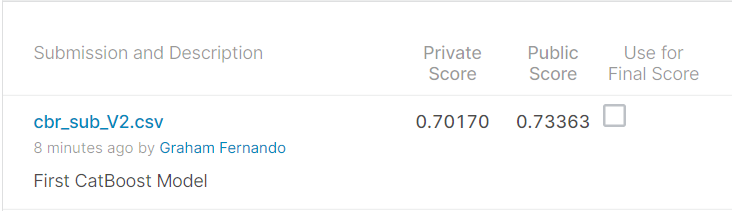

In [ ]:
for i in range(10):
    lr = np.round(np.random.rand()/10,3)
    min_child_weight  = np.random.randint(30,150)
    max_leaves = np.random.randint(30,100)

    xgb = XGBRegressor(objective='reg:squarederror',tree_method = 'hist', learning_rate = lr,min_child_weight = min_child_weight, 
                       subsample = 0.7, colsample_bytree = 0.7, n_estimators = 100,grow_policy = 'lossguide',
                       max_leaves = max_leaves, n_jobs=-1 ) 
    
    xgb.fit(X_train,y_train)
    y_pred = xgb.predict(X_val)
    rmse = mse(y_val,y_pred)

    print(f"For learning rate {lr}, min_child_weight {min_child_weight} and max_leaves {max_leaves} the RMSE is {rmse} ")
    print('*'*80)

For learning rate 0.071, min_child_weight 97 and max_leaves 74 the RMSE is 5.130997235548195 
********************************************************************************
For learning rate 0.074, min_child_weight 119 and max_leaves 86 the RMSE is 5.114757907043766 
********************************************************************************
For learning rate 0.05, min_child_weight 115 and max_leaves 60 the RMSE is 5.170266210649444 
********************************************************************************
For learning rate 0.044, min_child_weight 59 and max_leaves 68 the RMSE is 5.20024316505762 
********************************************************************************
For learning rate 0.017, min_child_weight 139 and max_leaves 98 the RMSE is 5.965988773280025 
********************************************************************************
For learning rate 0.06, min_child_weight 55 and max_leaves 79 the RMSE is 5.144295820247376 
*******************************

In [ ]:
lr = 0.074
min_child_weight  = 119
max_leaves = 86

In [ ]:
# Now that we have found the best model which has the lowest RMSE score, we are using that parameter values to retrain the model.

xgb = XGBRegressor(objective='reg:squarederror',tree_method = 'hist', learning_rate = lr,min_child_weight = min_child_weight, 
                       subsample = 0.7, colsample_bytree = 0.7, n_estimators = 100,grow_policy = 'lossguide',
                       max_leaves = max_leaves, n_jobs=-1 )
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)

# Now that it has predicted the values for X_val, we are calculating it's rmse
rmse = mse(y_val,y_pred)
print(f"For learning rate {lr}, min_child_weight {min_child_weight} and max_leaves {max_leaves} the RMSE is {rmse} ")

For learning rate 0.074, min_child_weight 119 and max_leaves 86 the RMSE is 5.114757907043766 


In [ ]:
# Now we are predicting the values for teh X_val and X_test for the submission

pred_val_array  = xgb.predict(X_val)
pred_test_array  = xgb.predict(X_test)

pred_val_array = np.reshape(pred_val_array, (-1, 28),order = 'F')
pred_test_array = np.reshape(pred_test_array, (-1, 28),order = 'F')

In [ ]:
sub = pd.read_csv("sample_submission.csv")
sub_1 = sub.iloc[:30490,:]
sub_2 = sub.iloc[30490:,:]
f_cols = sub.columns[1:]

for i in range(len(f_cols)):
    sub_1[f_cols[i]] = pred_val_array[:,i]
    sub_2[f_cols[i]] = pred_test_array[:,i]

sub = pd.concat([sub_1,sub_2])
sub

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.835742,0.718145,0.607976,0.355319,0.894233,0.856304,0.890733,0.731268,1.386984,0.717000,1.338368,1.063138,1.197387,1.079604,0.387778,1.256892,0.631730,0.759092,0.863617,0.962658,0.892708,0.763987,0.932513,0.748429,1.182228,0.857212,1.245363,0.832943
1,HOBBIES_1_002_CA_1_validation,0.441333,0.331783,0.311499,0.371564,0.304031,0.379704,0.358983,0.333902,0.239943,0.234309,0.378041,0.287863,0.339129,0.329618,0.312806,0.234309,0.241892,0.330559,0.260931,0.308321,0.330697,0.281215,0.236257,0.341417,0.282726,0.337684,0.313442,0.293158
2,HOBBIES_1_003_CA_1_validation,0.342639,0.374224,0.263008,0.242724,0.378700,1.023184,0.505449,0.272595,0.480061,0.240775,0.358462,0.325895,1.068514,0.385301,0.273392,0.361753,0.360410,0.606821,0.643970,1.314468,0.971687,0.443409,0.721855,0.490898,0.573095,0.668340,0.532103,0.754865
3,HOBBIES_1_004_CA_1_validation,2.048544,1.199387,0.622713,1.464883,1.391016,1.848323,3.261893,1.432481,1.065727,0.749135,1.512859,1.530638,2.086873,3.114543,2.018768,1.159155,1.286072,0.993960,1.574472,1.783782,2.962968,1.841518,1.415629,1.363736,1.175682,1.463305,2.582619,2.777621
4,HOBBIES_1_005_CA_1_validation,0.978402,0.911024,1.258985,1.133430,1.316534,1.243119,1.480329,0.827557,1.361461,0.842301,1.136792,0.751990,0.784973,1.092074,1.096029,0.781715,1.193064,0.899196,1.053998,0.809275,1.348276,0.944672,0.725195,0.871579,1.115088,1.232938,1.139363,1.863808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.411936,0.334384,0.268641,0.612029,0.695733,0.559127,0.618719,0.393145,0.552438,0.278259,0.772104,0.723270,0.441830,0.587337,0.511838,0.543031,0.388171,0.455552,0.792000,0.389230,0.990007,0.409454,0.895627,0.461278,0.485073,0.687376,0.491698,0.831563
60976,FOODS_3_824_WI_3_evaluation,0.506807,0.421720,0.373801,0.439544,0.334384,0.486180,0.351251,0.437836,0.451071,0.337851,0.692143,0.294578,0.643103,0.373965,0.450009,0.411955,0.330930,0.541526,0.266693,0.398281,0.380603,0.417566,0.362377,0.314204,0.534774,0.268641,0.557409,0.319497
60977,FOODS_3_825_WI_3_evaluation,1.246269,0.479622,0.829673,0.379443,0.702812,0.925911,0.596644,1.345465,0.354102,0.833346,0.441296,0.530256,0.799096,0.709618,1.025482,0.832118,1.169983,0.856102,0.791538,0.735720,0.717125,1.211386,0.677291,1.272739,0.387363,0.558909,0.566021,0.914211
60978,FOODS_3_826_WI_3_evaluation,0.964555,1.722158,0.812057,1.330379,1.144919,0.942219,1.673292,1.184949,1.096096,1.087131,1.237263,1.169922,1.305601,1.448973,1.339930,1.073835,0.970817,1.112249,1.296108,1.020384,1.255445,1.601080,2.083296,1.416716,1.899925,1.031471,0.982772,1.077861


In [ ]:
sub.to_csv("xgb_sub_V1.csv",index = False)

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f xgb_sub_V1.csv -m "First XGBoost Model"

100% 18.5M/18.5M [00:03<00:00, 5.59MB/s]
Successfully submitted to M5 Forecasting - Accuracy

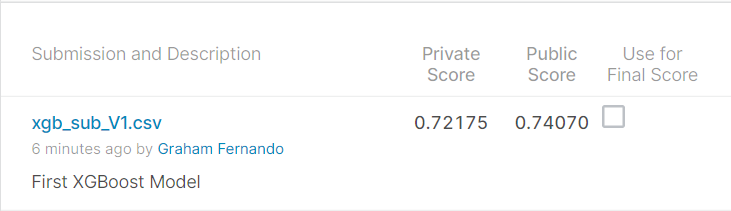